In [1]:
import collections
import math
import os
import random
import zipfile
import urllib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [4]:
vocabulary_size = 50000
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    word2index = {}
    for word, _ in count:
        word2index[word] = len(word2index)
    data = [] # encoded words
    unk_count = 0
    for word in words:
        if word in word2index:
            index = word2index[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    index2word = dict(zip(word2index.values(), word2index.keys()))
    return data, count, word2index, index2word

data, count, word2index, index2word = build_dataset(words)

In [5]:
del words
print('Most common words (+Unknown)', count[:5])
print('Sample data', data[:10], [index2word[i] for i in data[:10]])

Most common words (+Unknown) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
data_index = 0

def generate_batch(batch_size, num_sample, window_size):
    global data_index
    assert batch_size % num_sample == 0, 'a batch should contain all samples of a word.'
    assert  num_sample <= window_size * 2, 'we can\'t generated more than 2 * windows_size samples.'
    batch = np.ndarray(shape = (batch_size), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * window_size + 1
    buffer = collections.deque(maxlen = span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_sample):
        targets_to_avoid = [window_size] # avoid duplicate samples
        target = window_size
        for j in range(num_sample):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_sample + j] = buffer[window_size]
            labels[i * num_sample + j, 0] = buffer[target]
            buffer.append(data[data_index])
            data_index = (data_index + 1) % len(data)
    return batch, labels  

In [7]:
batch_size = 128
vector_size = 128 # dimension of dense word vectors
window_size = 1
num_sample = 2

valid_size = 16 # number of words for validation
valid_window = 100 # top n frequent words for validation 
valid_examples = np.random.choice(valid_window, valid_size, replace = False)
num_neg_sampled = 64

In [8]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype = tf.int32)

word_vectors = tf.Variable(tf.random_normal([vocabulary_size, vector_size]))
inputs_vectors = tf.nn.embedding_lookup(word_vectors, inputs)

nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, vector_size], stddev = 1.0 / math.sqrt(vector_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights, biases = nce_biases, labels = labels, inputs = inputs_vectors,
                                    num_sampled = num_neg_sampled, num_classes = vocabulary_size))

train = tf.train.AdamOptimizer(1e-3).minimize(loss)

normalized_word_vectors = word_vectors / tf.sqrt(tf.reduce_sum(tf.square(word_vectors), 1, keep_dims = True))

valid_vectors = tf.nn.embedding_lookup(normalized_word_vectors, valid_dataset)
similarity = tf.matmul(valid_vectors, normalized_word_vectors, transpose_b = True)

In [9]:
num_steps = 100000
show_loss = 2000
show_similarity = 10000
top_k = 8
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    avg_loss = 0
    for step in range(1, num_steps + 1):
        x_batch, y_batch = generate_batch(batch_size, num_sample, window_size)
        _, loss_val = sess.run([train, loss], feed_dict = {inputs : x_batch, labels : y_batch})
        avg_loss += loss_val
        if step % show_loss == 0:
            avg_loss /= 2000
            print("Average loss at step ", step,": ", avg_loss)
            avg_loss = 0
        if step % show_similarity == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = index2word[valid_examples[i]]
                nearest = (-sim[i, :]).argsort()[1 : top_k + 1] # 0 is itself
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = index2word[nearest[k]]
                    log_str = "%s %s " % (log_str, close_word)
                print(log_str)
    final_words_vectors = normalized_word_vectors.eval()

Average loss at step  2000 :  211.431253769
Average loss at step  4000 :  129.185713583
Average loss at step  6000 :  92.1745859671
Average loss at step  8000 :  69.6757881155
Average loss at step  10000 :  55.06529179
Nearest to which: this  only  were  is  at  that  possible  been 
Nearest to may: other  nine  all  one  u  references  four  can 
Nearest to american: four  five  well  which  also  zero  this  all 
Nearest to often: with  it  UNK  is  well  two  its  which 
Nearest to eight: four  zero  three  five  nine  this  two  seven 
Nearest to it: four  first  are  is  itself  five  UNK  known 
Nearest to will: be  zero  it  which  d  made  found  use 
Nearest to united: against  two  three  four  one  six  first  army 
Nearest to his: UNK  two  with  eight  a  also  been  being 
Nearest to UNK: four  one  five  his  first  many  three  john 
Nearest to world: four  others  zero  its  with  from  at  seven 
Nearest to six: zero  two  five  four  eight  where  one  three 
Nearest

Average loss at step  66000 :  8.84542500687
Average loss at step  68000 :  8.76824957669
Average loss at step  70000 :  9.46642115843
Nearest to which: this  that  and  it  what  reasoning  also  only 
Nearest to may: can  would  should  will  might  could  must  to 
Nearest to american: french  heritage  alan  and  german  UNK  theorems  unemployment 
Nearest to often: sometimes  commonly  generally  never  which  usually  also  it 
Nearest to eight: four  five  three  nine  zero  seven  six  two 
Nearest to it: this  he  itself  they  which  there  not  what 
Nearest to will: would  should  might  can  could  may  to  cannot 
Nearest to united: throughout  and  communist  heritage  army  largest  house  arguably 
Nearest to his: their  its  her  the  my  keeping  him  s 
Nearest to UNK: and  advent  arm  the  one  businesses  lands  four 
Nearest to world: round  economy  mind  twentieth  civil  thirty  journal  impression 
Nearest to six: five  four  two  eight  seven  three  zero 

In [10]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize = (18, 18))
    for i,label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom')
    plt.savefig(filename)

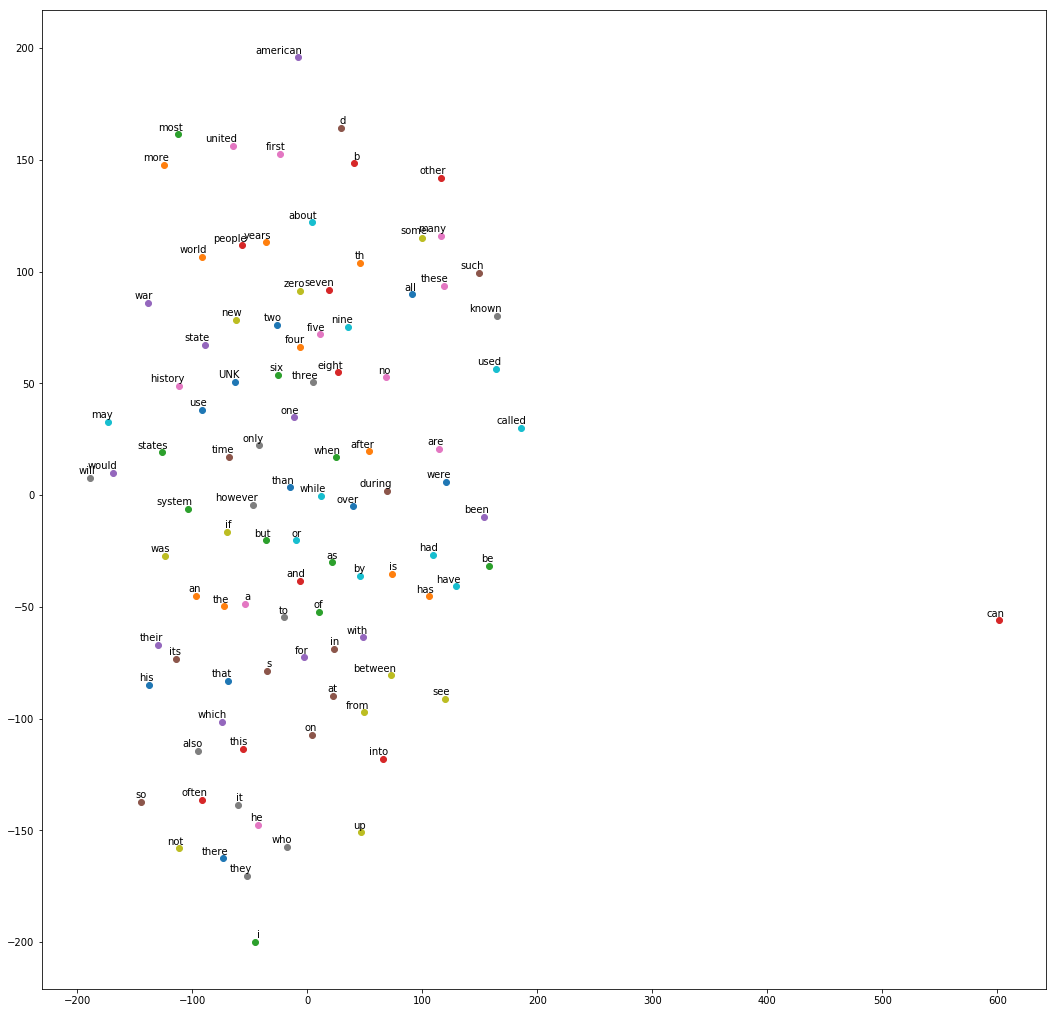

In [11]:
tsne = TSNE(perplexity =  30, n_components = 2, init = 'pca', n_iter = 5000)
plot_only = 100
low_dim_embs = tsne.fit_transform(final_words_vectors[: plot_only, :])
labels = [index2word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)